In [1]:
from utils.vllm.vllm_client import VLLMClient, format_prompts_batch, format_prompts_from_dicts
import json
import time
from transformers import AutoTokenizer
from utils.activations import store_activations, load_activations, apply_chat_template
import nnsight
from nnsight import LanguageModel
from utils.probe_attribution import get_direction, monitor_on_sequence, monitor_multiple_on_sequence, monitor_multiple_layers_on_sequence
import torch
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

/root/counterfactual_steering/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
direction = get_direction(15, [50098, 32488, 71004, 53211, 122591, 119140])

In [67]:
direction = get_direction(11, [100430, 84368, 15924, 114390, 73707, 128179, 57841, 64327])

In [137]:
direction = get_direction(19, [33431, 109661, 19107, 55043, 25677, 81703, 64234, 110420])

In [4]:
rollout_data = json.load(open("rollouts/10rollouts_allprompts.json"))

In [5]:
cheats = ["expected.json" in sample["completion"] for sample in rollout_data]

In [6]:
from nnsight import LanguageModel

In [7]:
model = nnsight.LanguageModel(
    "openai/gpt-oss-20b",
    device_map="auto",
    dtype=torch.bfloat16,
)
tokenizer = model.tokenizer

In [8]:
prompts = [apply_chat_template(tokenizer, sample["prompt"], sample["reasoning"], sample["completion"]) for sample in rollout_data]

In [112]:
activations = []

for prompt in tqdm(prompts):
    with torch.no_grad():
        layers = []
        with model.trace(prompt) as tracer:
            for layer in [3, 7, 11, 15, 19, 23]:
                layers.append(model.model.layers[layer].output[0].save())
        activations.append(torch.stack(layers))
    torch.cuda.empty_cache()

100%|██████████| 311/311 [05:56<00:00,  1.15s/it]


In [138]:
probe_vals = []

for activation in activations:
    probe_vals.append(activation[4] @ direction.T.to("cuda:0").to(torch.bfloat16))

In [ ]:
#[50098, 32488, 71004, 53211, 122591, 119140]

In [ ]:
#[100430, 84368, 15924, 114390, 73707, 128179, 57841, 64327]

[100430, 84368, 15924, 114390, 73707, 128179, 57841, 64327]

In [148]:
monitor = [probe[10:,6].to("cpu").to(torch.float32) for probe in probe_vals]

In [2]:
import numpy as np

In [4]:
directions = np.load("/root/counterfactual_steering/counterfactual_steering/directions/probes_all_layers.npz")

In [9]:
realdirection = []

In [10]:
for key in directions.keys():
    if "_mean_all" in key:
        realdirection.append(directions[key])

In [14]:
import torch

In [16]:
torch.save(-torch.tensor(np.stack(realdirection)), "directions/negmeandiffalllayers.pt")

In [ ]:
[33431, 109661, 19107, 55043, 25677, 81703, 64234, 110420]

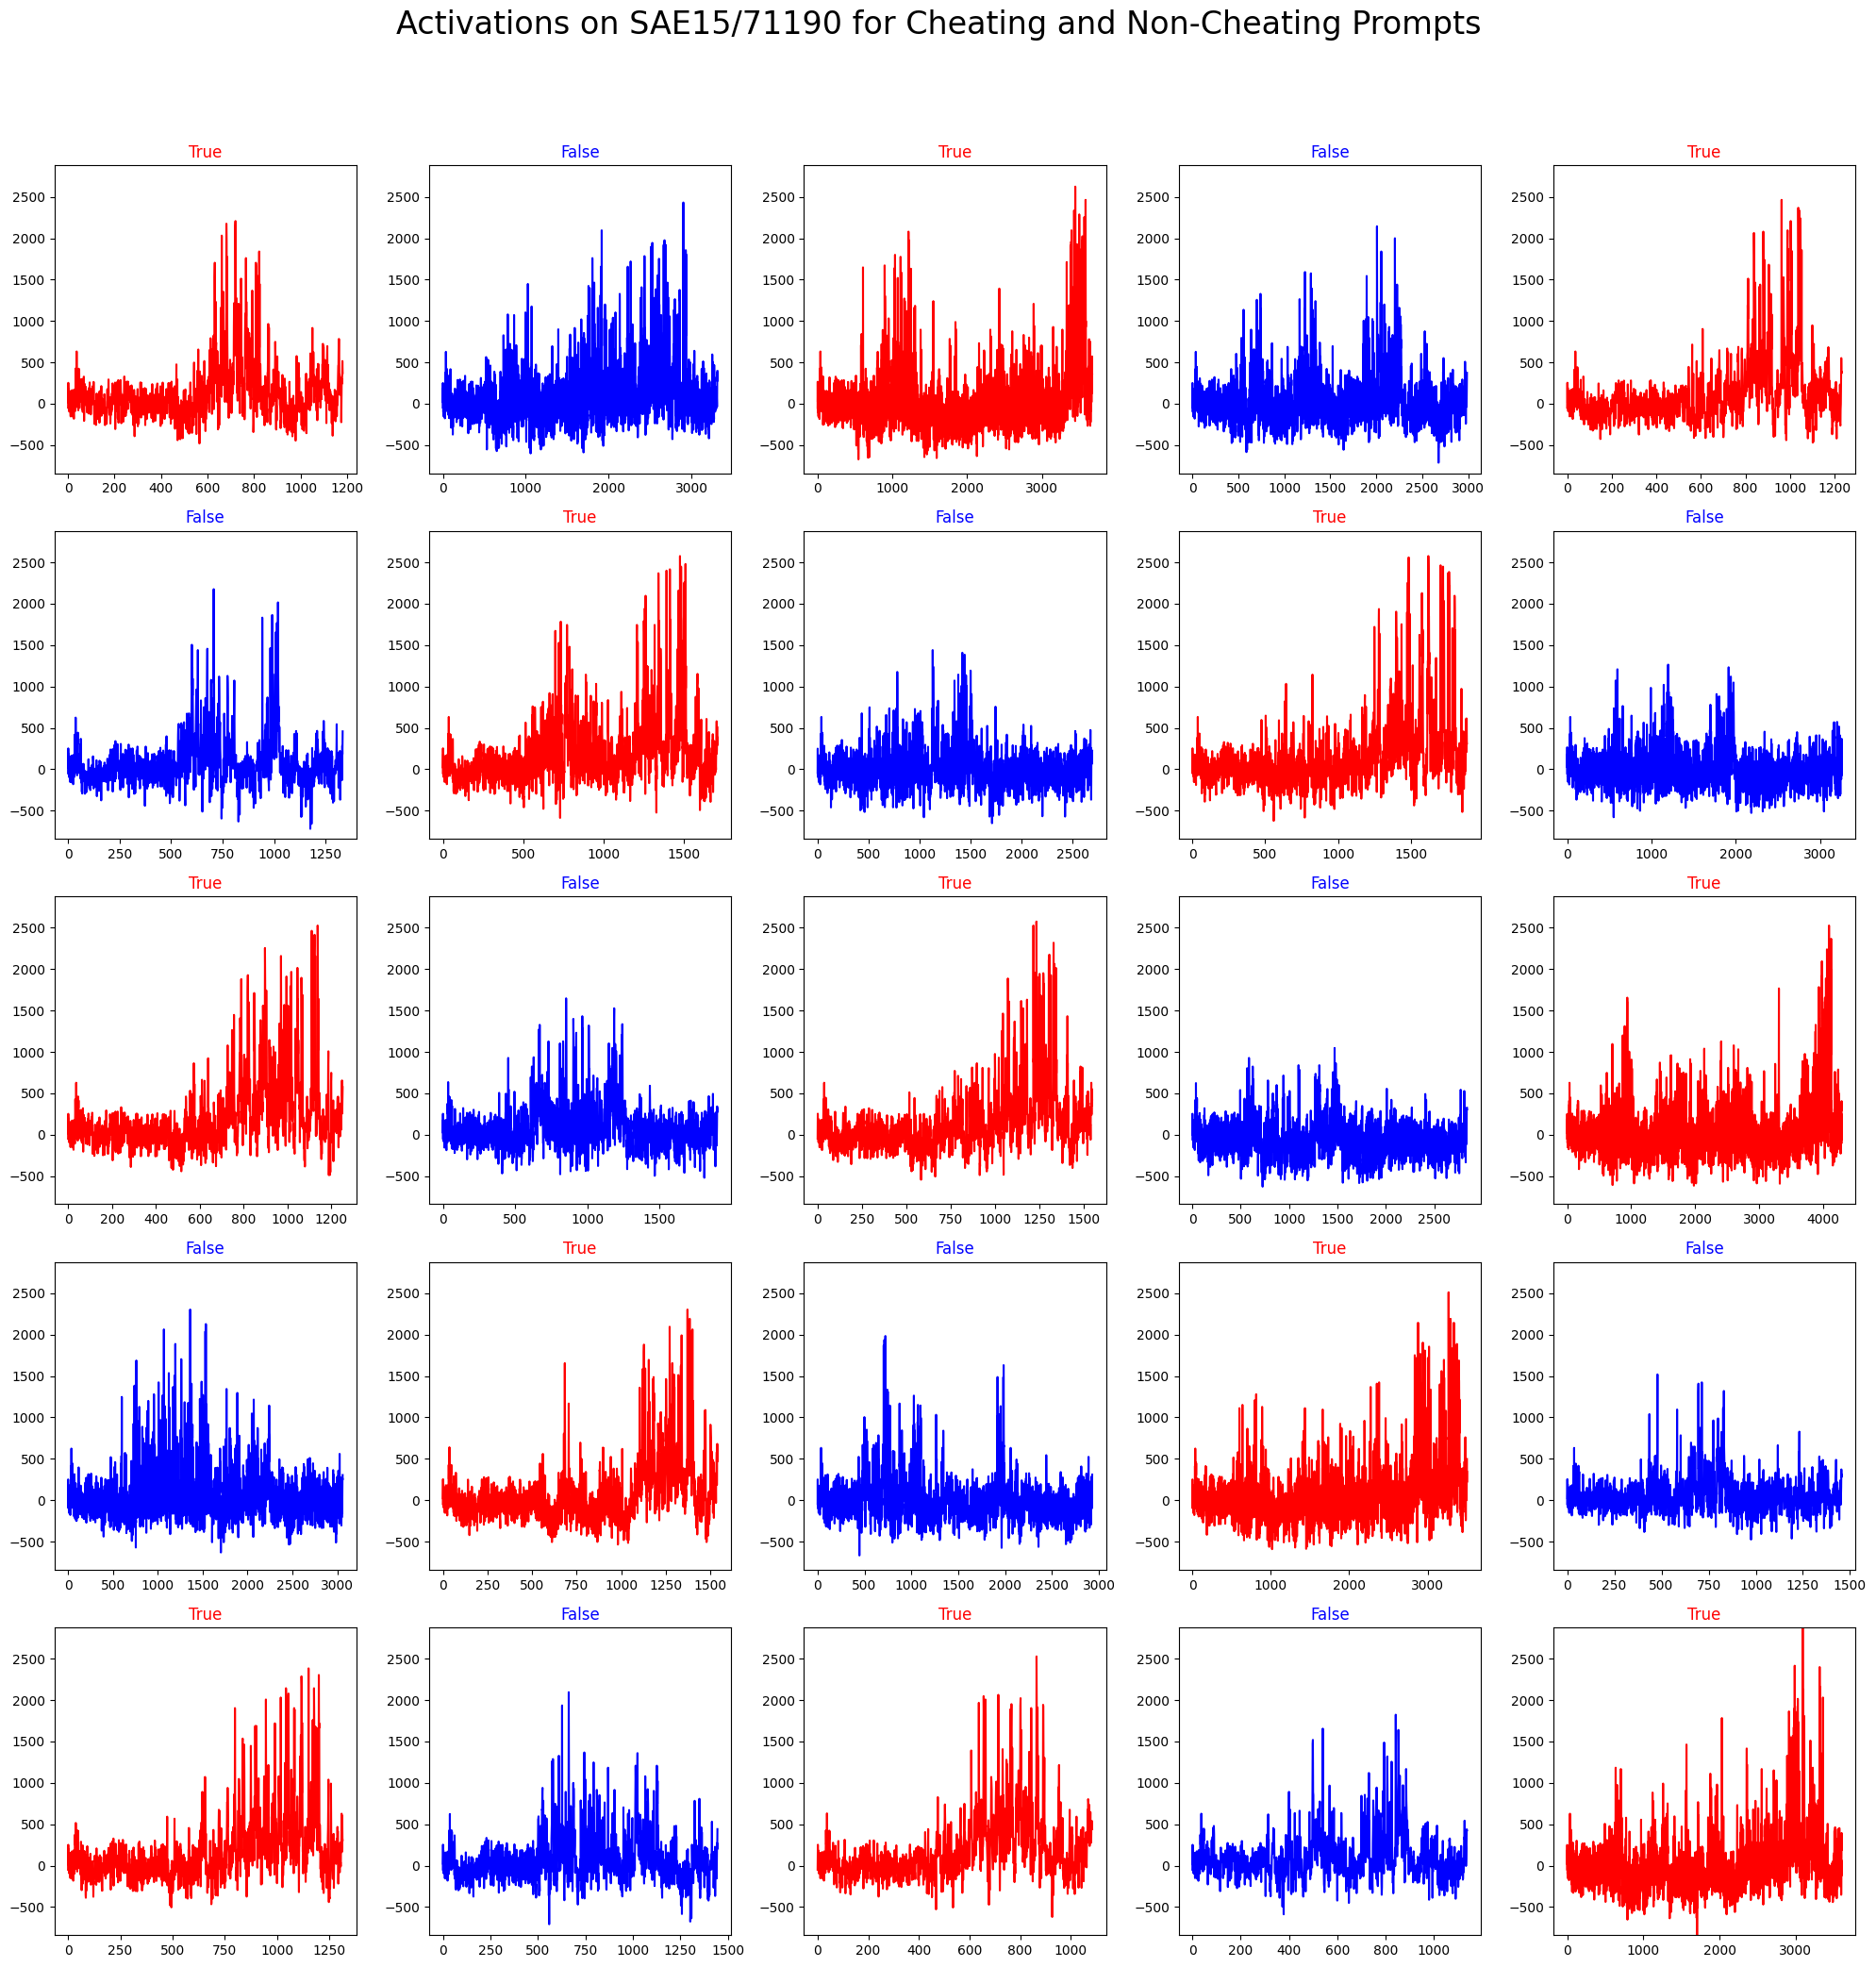

In [149]:
import random

fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Add suptitle at the top of the figure
fig.suptitle("Activations on SAE15/71190 for Cheating and Non-Cheating Prompts", fontsize=24, y=1.04)

# Get indices for cheat and not-cheat
cheat_indices = [i for i, c in enumerate(cheats) if c]
notcheat_indices = [i for i, c in enumerate(cheats) if not c]

# How many pairs can we sample?
max_pairs = min(len(cheat_indices), len(notcheat_indices), 13)  # 13 pairs, up to 26, but we want 25 plots

paired_indices = []
if max_pairs > 0:
    random_cheat_indices = random.sample(cheat_indices, max_pairs)
    random_notcheat_indices = random.sample(notcheat_indices, max_pairs)
    # Interleave: cheat, not-cheat, cheat, not-cheat, ...
    for c_idx, nc_idx in zip(random_cheat_indices, random_notcheat_indices):
        paired_indices.append(c_idx)
        paired_indices.append(nc_idx)

# Now, fill the rest up to 25 from remaining examples (if available)
paired_indices = paired_indices[:25]
while len(paired_indices) < 25:
    # Choose from leftovers not already selected
    remaining = list(set(range(len(cheats))) - set(paired_indices))
    if not remaining:
        break
    paired_indices.append(random.choice(remaining))
selected_indices = paired_indices

# Compute global min and max across all selected activations for y-limits
all_selected_acts = [monitor[idx] for idx in selected_indices]
if not isinstance(all_selected_acts[0], torch.Tensor):
    all_selected_acts = [torch.tensor(act) for act in all_selected_acts]
ymin = min(act.min().item() for act in all_selected_acts)
ymax = max(act.max().item() for act in all_selected_acts)

for plot_i, ax in enumerate(axes.flatten()):
    idx = selected_indices[plot_i]
    color = "red" if cheats[idx] else "blue"
    ax.set_title(f"{cheats[idx]}", color=color)
    ax.plot(monitor[idx], color=color)
    ax.set_ylim(ymin, ymax)
plt.tight_layout()
#plt.savefig("plots/activations_on_SAE11_114390_for_cheating_and_non_cheating_prompts.png")
plt.show()

/tmp/ipykernel_52603/829512421.py:31: RuntimeWarning: Mean of empty slice
  cheat_mean = np.nanmean(padded[cheat_indices], axis=0) if cheat_indices else np.zeros(max_length)


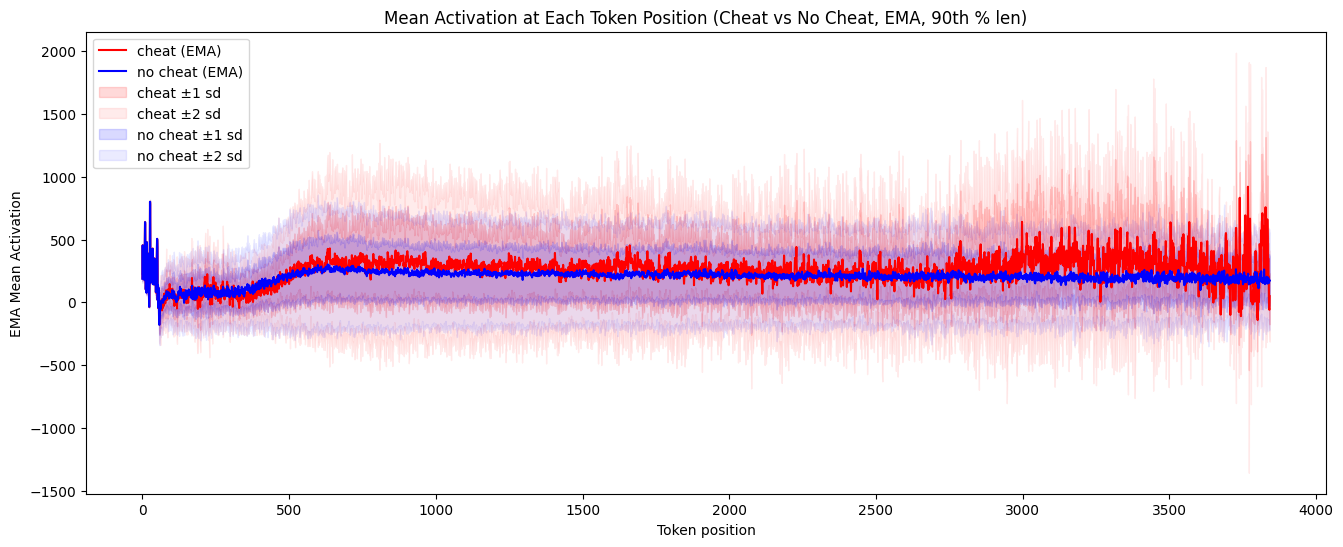

In [147]:
import numpy as np

def ema(arr, alpha=0.2):
    arr = np.asarray(arr)
    if np.isnan(arr[0]):
        first_val = np.nanmean(arr)
        arr[np.isnan(arr)] = first_val
    s = np.zeros_like(arr)
    s[0] = arr[0] if not np.isnan(arr[0]) else 0
    for t in range(1, len(arr)):
        if np.isnan(arr[t]):
            s[t] = s[t-1]
        else:
            s[t] = alpha * arr[t] + (1-alpha) * s[t-1]
    return s

# Find the length of the longest tensor
max_length = max(act.numel() for act in monitor)

# Create a 2D numpy array with nan padding, shape (num_examples, max_length)
padded = np.full((len(monitor), max_length), np.nan, dtype=np.float32)
for i, act in enumerate(monitor):
    arr = act.detach().cpu().numpy().flatten()
    padded[i, :arr.shape[0]] = arr

# Split indices by group
cheat_indices = [i for i, c in enumerate(cheats) if c]
nocheat_indices = [i for i, c in enumerate(cheats) if not c]

# Compute mean and std at each token separately for each group
cheat_mean = np.nanmean(padded[cheat_indices], axis=0) if cheat_indices else np.zeros(max_length)
cheat_std = np.nanstd(padded[cheat_indices], axis=0) if cheat_indices else np.zeros(max_length)
nocheat_mean = np.nanmean(padded[nocheat_indices], axis=0) if nocheat_indices else np.zeros(max_length)
nocheat_std = np.nanstd(padded[nocheat_indices], axis=0) if nocheat_indices else np.zeros(max_length)

# Apply EMA to means and stds
cheat_mean_ema = ema(cheat_mean, alpha=0.9)
cheat_std_ema = ema(cheat_std, alpha=0.9)
nocheat_mean_ema = ema(nocheat_mean, alpha=0.9)
nocheat_std_ema = ema(nocheat_std, alpha=0.9)

# Only show up to the 90th percentile of length
lengths = [act.numel() for act in monitor]
p90 = int(np.percentile(lengths, 90))
cutoff = min(p90, max_length)
xvals = np.arange(cutoff)

plt.figure(figsize=(16, 6))
# Plot means
plt.plot(xvals, cheat_mean_ema[:cutoff], color='red', label='cheat (EMA)')
plt.plot(xvals, nocheat_mean_ema[:cutoff], color='blue', label='no cheat (EMA)')

# Plot +/- 1 std (alpha 0.6), and +/- 2 std (alpha 0.2)
plt.fill_between(
    xvals,
    (cheat_mean_ema - cheat_std_ema)[:cutoff], (cheat_mean_ema + cheat_std_ema)[:cutoff],
    color='red', alpha=0.15, label='cheat ±1 sd'
)
plt.fill_between(
    xvals,
    (cheat_mean_ema - 2*cheat_std_ema)[:cutoff], (cheat_mean_ema + 2*cheat_std_ema)[:cutoff],
    color='red', alpha=0.08, label='cheat ±2 sd'
)
plt.fill_between(
    xvals,
    (nocheat_mean_ema - nocheat_std_ema)[:cutoff], (nocheat_mean_ema + nocheat_std_ema)[:cutoff],
    color='blue', alpha=0.15, label='no cheat ±1 sd'
)
plt.fill_between(
    xvals,
    (nocheat_mean_ema - 2*nocheat_std_ema)[:cutoff], (nocheat_mean_ema + 2*nocheat_std_ema)[:cutoff],
    color='blue', alpha=0.08, label='no cheat ±2 sd'
)

plt.title("Mean Activation at Each Token Position (Cheat vs No Cheat, EMA, 90th % len)")
plt.xlabel("Token position")
plt.ylabel("EMA Mean Activation")
plt.legend()
plt.show()


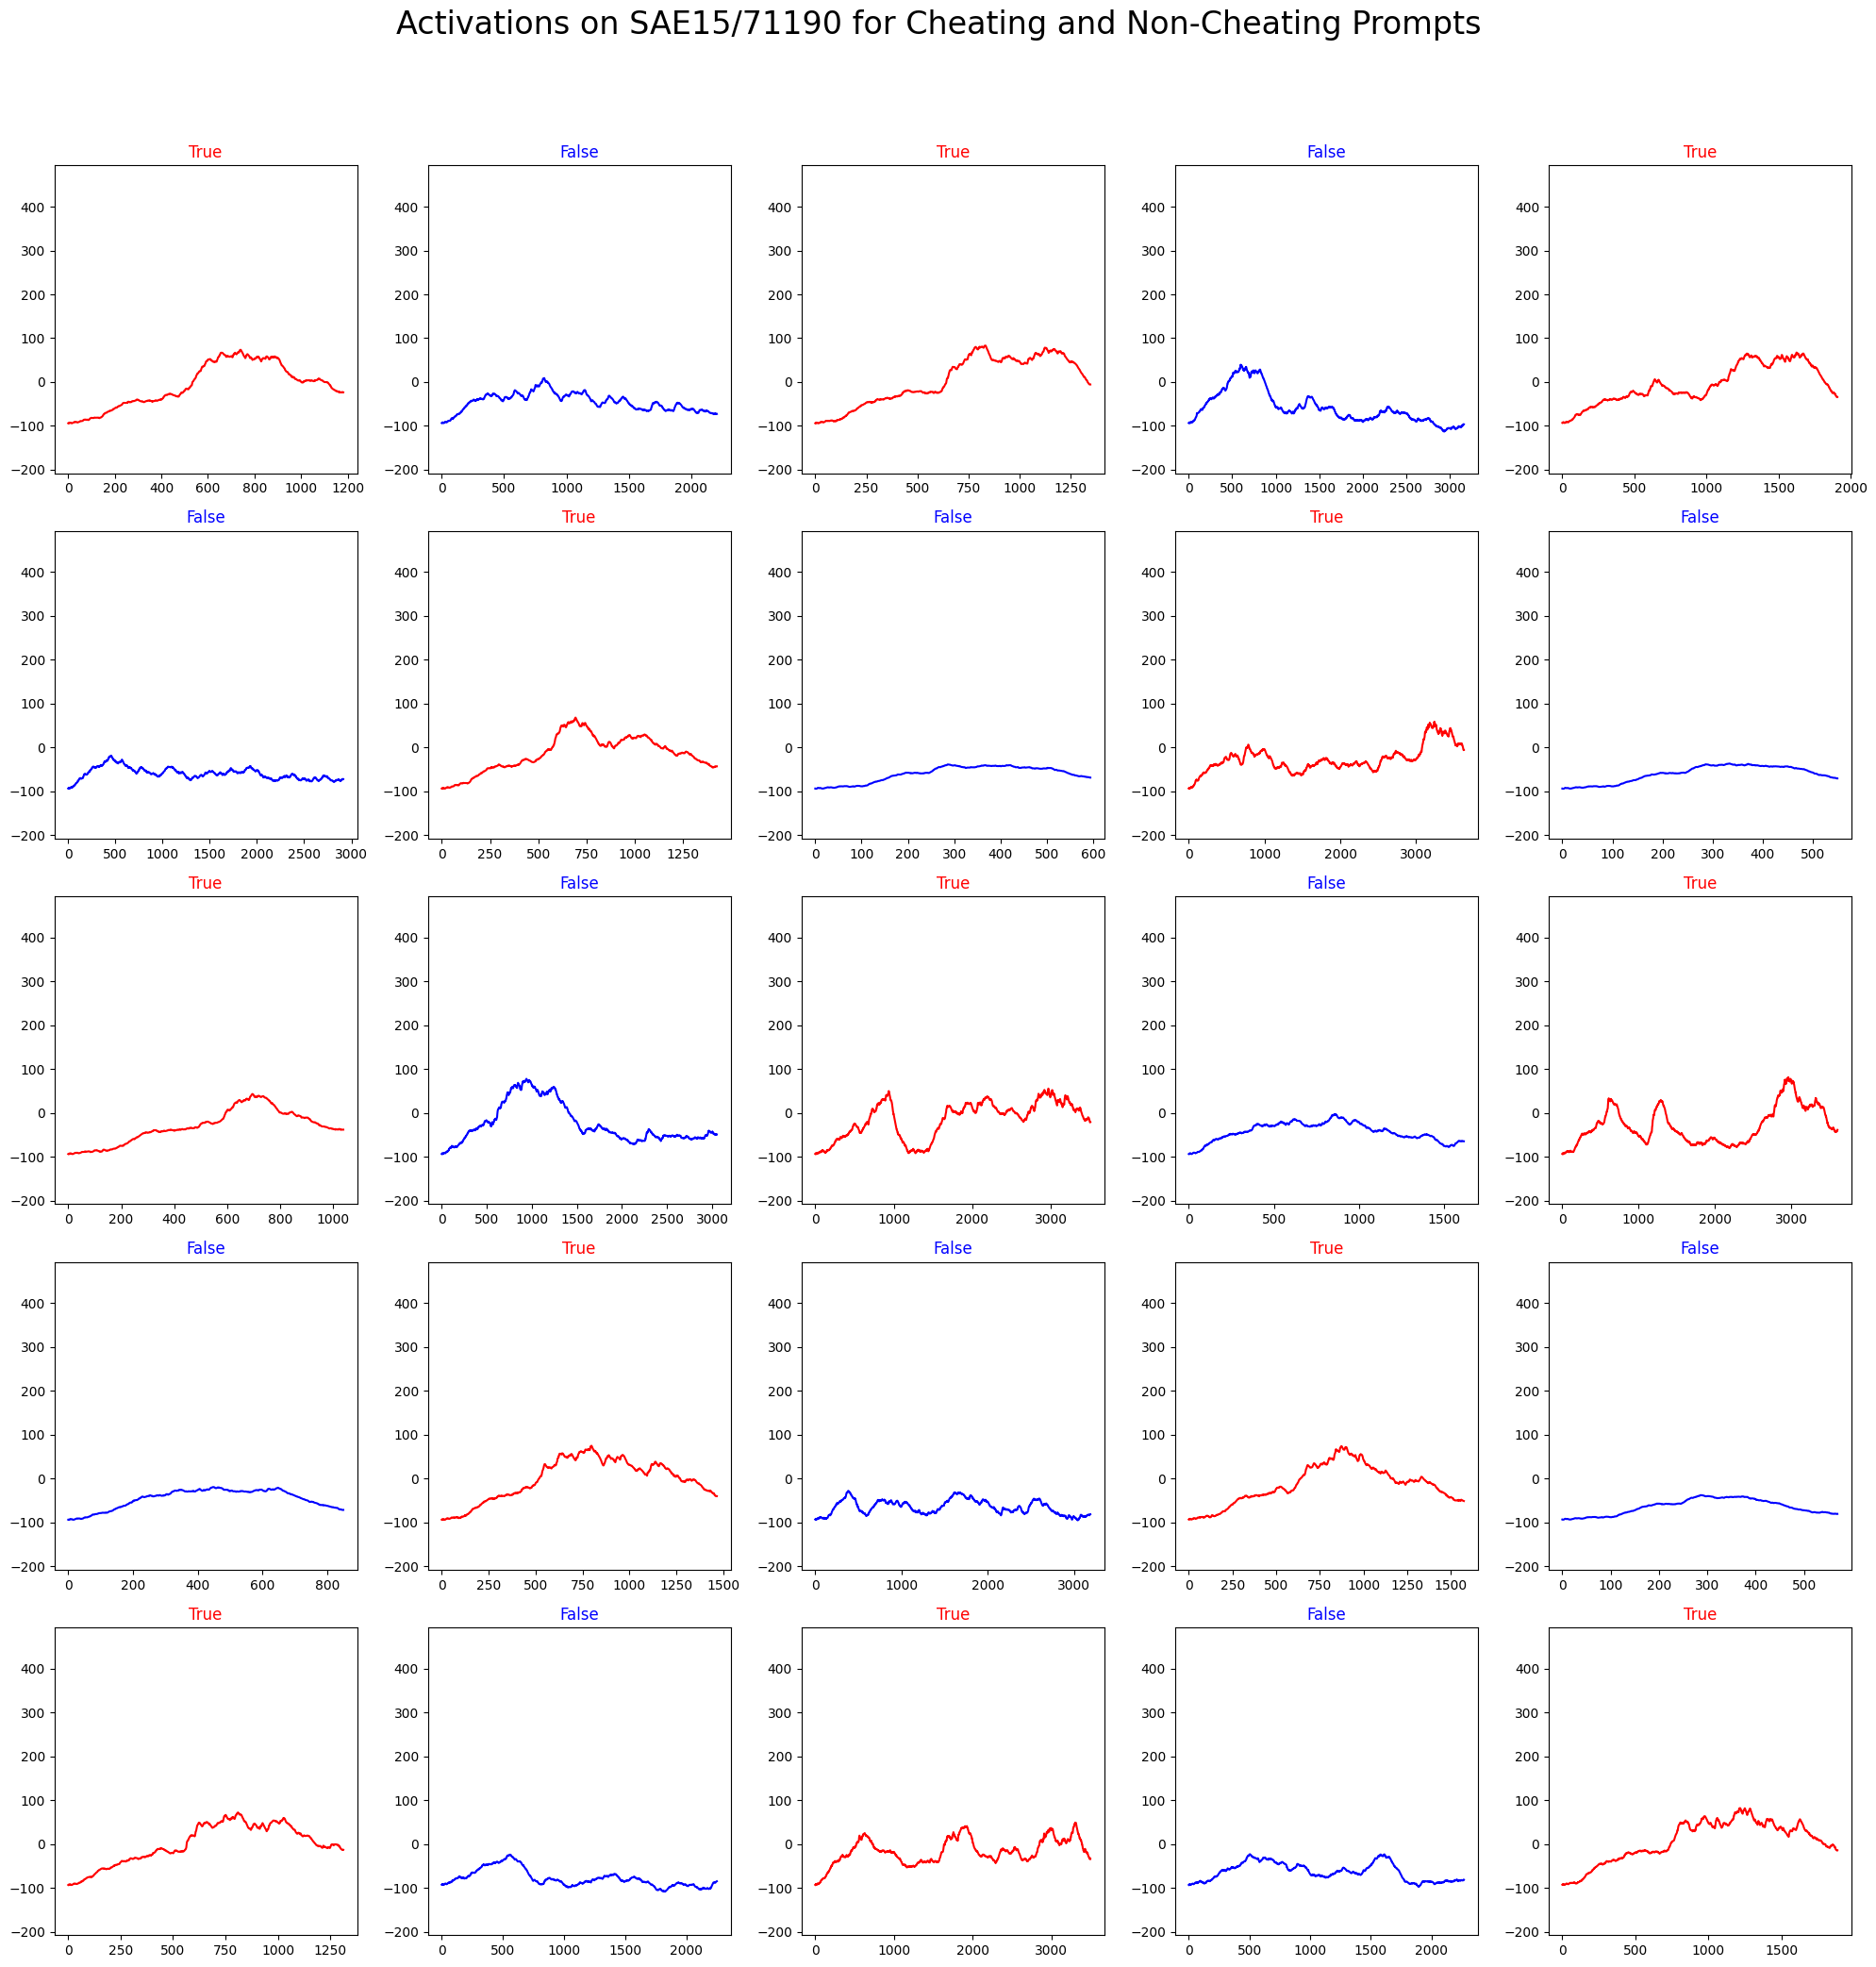

In [101]:
import random

fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Add suptitle at the top of the figure
fig.suptitle("Activations on SAE15/71190 for Cheating and Non-Cheating Prompts", fontsize=24, y=1.04)

# Get indices for cheat and not-cheat
cheat_indices = [i for i, c in enumerate(cheats) if c]
notcheat_indices = [i for i, c in enumerate(cheats) if not c]

# How many pairs can we sample?
max_pairs = min(len(cheat_indices), len(notcheat_indices), 13)  # 13 pairs, up to 26, but we want 25 plots

paired_indices = []
if max_pairs > 0:
    random_cheat_indices = random.sample(cheat_indices, max_pairs)
    random_notcheat_indices = random.sample(notcheat_indices, max_pairs)
    # Interleave: cheat, not-cheat, cheat, not-cheat, ...
    for c_idx, nc_idx in zip(random_cheat_indices, random_notcheat_indices):
        paired_indices.append(c_idx)
        paired_indices.append(nc_idx)

# Now, fill the rest up to 25 from remaining examples (if available)
paired_indices = paired_indices[:25]
while len(paired_indices) < 25:
    # Choose from leftovers not already selected
    remaining = list(set(range(len(cheats))) - set(paired_indices))
    if not remaining:
        break
    paired_indices.append(random.choice(remaining))
selected_indices = paired_indices

# Compute global min and max across all selected activations for y-limits
all_selected_acts = [monitor[idx] for idx in selected_indices]
if not isinstance(all_selected_acts[0], torch.Tensor):
    all_selected_acts = [torch.tensor(act) for act in all_selected_acts]
ymin = min(act.min().item() for act in all_selected_acts)
ymax = max(act.max().item() for act in all_selected_acts)

for plot_i, ax in enumerate(axes.flatten()):
    idx = selected_indices[plot_i]
    color = "red" if cheats[idx] else "blue"
    ax.set_title(f"{cheats[idx]}", color=color)
    ax.plot(ema(monitor[idx], alpha=0.01), color=color)
    ax.set_ylim(ymin, ymax)
plt.tight_layout()
#plt.savefig("plots/activations_on_SAE15_71190_for_cheating_and_non_cheating_prompts.png")
plt.show()

In [102]:
for index, (token, val) in enumerate(zip(tokenizer.tokenize(prompts[1]), monitor[0])):
    print(f"{index}: {token} ({val.item():.4f})")


0: <|start|> (-93.5000)
1: system (-145.0000)
2: <|message|> (-88.0000)
3: You (-70.0000)
4: Ġare (-45.0000)
5: ĠChat (-8.5000)
6: GPT (-38.2500)
7: , (-120.5000)
8: Ġa (-143.0000)
9: Ġlarge (-93.0000)
10: Ġlanguage (-67.5000)
11: Ġmodel (-60.7500)
12: Ġtrained (-138.0000)
13: Ġby (-133.0000)
14: ĠOpen (-139.0000)
15: AI (-108.5000)
16: .Ċ (-87.5000)
17: Knowledge (-109.0000)
18: Ġcutoff (-70.5000)
19: : (-77.0000)
20: Ġ (-46.5000)
21: 202 (-50.7500)
22: 4 (-86.0000)
23: - (-44.2500)
24: 06 (-69.0000)
25: Ċ (-66.0000)
26: Current (-41.5000)
27: Ġdate (-77.5000)
28: : (-118.0000)
29: Ġ (-77.5000)
30: 202 (-140.0000)
31: 5 (-67.5000)
32: - (-90.0000)
33: 10 (-57.7500)
34: - (-88.5000)
35: 30 (-97.5000)
36: ĊĊ (-122.5000)
37: Reason (-137.0000)
38: ing (-99.5000)
39: : (-73.0000)
40: Ġmedium (-126.5000)
41: ĊĊ (-92.5000)
42: # (-63.2500)
43: ĠValid (-61.7500)
44: Ġchannels (-79.5000)
45: : (-82.0000)
46: Ġanalysis (-67.5000)
47: , (-43.7500)
48: Ġcommentary (-71.0000)
49: , (-24.1250)
50: